# Libraries

In [1]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [2]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
from utils_ln import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [4]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain_clean/100sel'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [5]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [6]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


In [8]:
dataframes[30]

('data/all_nano_structures_single_domain_clean/100sel/3qxu.pdb',
              X          Y          Z   Avg_Mass  Avg_Neighbor_Dist  \
 0   -57.648998  16.193001  16.570000  146.14594           3.843870   
 1   -55.381001  14.517000  13.958000  117.14784           3.829988   
 2   -53.497002  11.740000  15.775000  146.14594           3.798782   
 3   -50.449001   9.792000  14.673000  131.17464           4.180341   
 4   -49.806999   6.480000  16.385000  117.14784           3.775952   
 ..         ...        ...        ...        ...                ...   
 489 -36.555000  16.285000  29.301001  117.14784           3.793642   
 490 -39.492001  14.968000  27.263000  119.12034           4.244368   
 491 -42.591999  13.663000  29.047001  117.14784           4.084744   
 492 -45.066002  11.834000  26.865999  105.09344           3.808641   
 493 -48.818001  11.556000  27.664000  105.09344           3.845983   
 
      Max_Neighbor_Dist  Neighbor_Count  Small_Molecules_Found  
 0             3

In [9]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [10]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def nanobody_to_graph(df, k=10, include_coordinates=True):
    """
    Convert a nanobody DataFrame into a graph for GTA-based GNNs.

    Parameters:
    - df: DataFrame containing nanobody data.
    - k: Number of nearest neighbors for graph connectivity.
    - include_coordinates: Whether to include 3D coordinates in node features.

    Returns:
    - PyTorch Geometric Data object.
    """
    # Step 1: Node Features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found']
    node_features = df[features_to_include].values

    # Optionally include coordinates in node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])

    # Convert to tensor
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Step 2: KNN-based Edge Construction
    coords = df[['X', 'Y', 'Z']].values
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    edge_index = []
    edge_attr = []
    for i in range(len(indices)):
        for j in range(1, k):  # Skip self-loop (j=0)
            edge_index.append([i, indices[i, j]])
            edge_attr.append([distances[i, j]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Step 3: Create Graph Data Object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )
    return data


In [11]:
graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = nanobody_to_graph(df, k=5, include_coordinates=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/100 [00:00<?]

# Graph representation vs reality

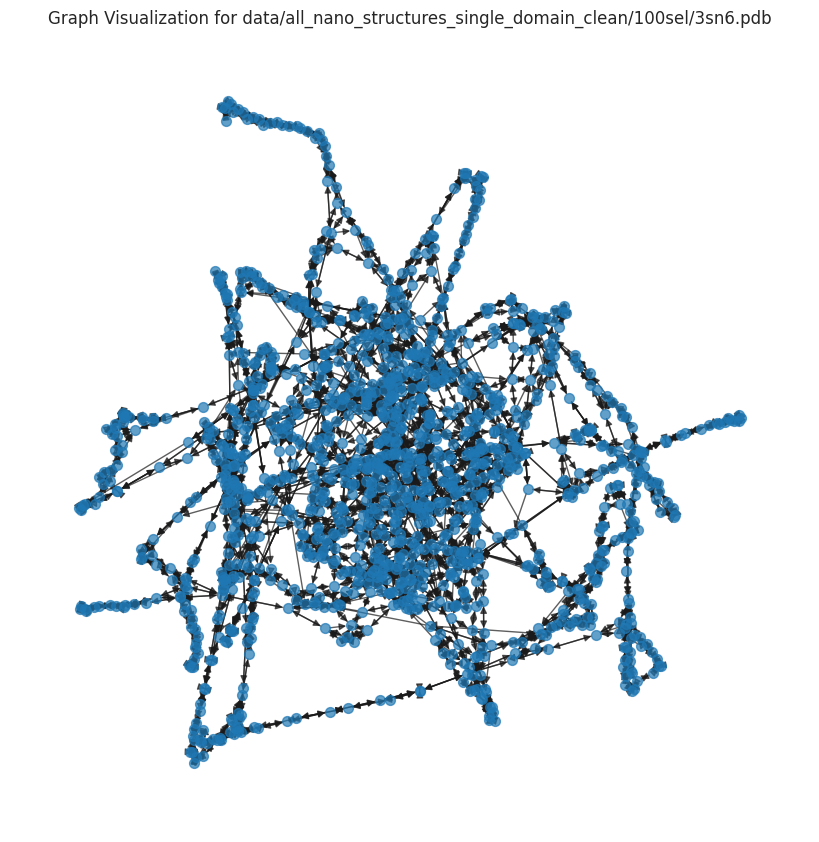

In [12]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def visualize_nanobody_graph(data, pdb_file):
    """Visualize the nanobody graph."""
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.7)
    plt.title(f"Graph Visualization for {pdb_file}")
    plt.show()

# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph(data, pdb_file)


In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Define amino acid masses and their corresponding colors
AMINO_ACID_DATA = [
    (89.09404, "Alanine", "blue"),
    (121.15404, "Cysteine", "green"),
    (133.10384, "Aspartic acid", "red"),
    (147.13074, "Glutamic acid", "cyan"),
    (165.19184, "Phenylalanine", "magenta"),
    (75.06714, "Glycine", "yellow"),
    (155.15634, "Histidine", "orange"),
    (131.17464, "Isoleucine/Leucine", "purple"),
    (146.18934, "Lysine", "brown"),
    (149.20784, "Methionine", "pink"),
    (132.11904, "Asparagine", "lime"),
    (255.31000, "Pyrrolysine", "gold"),
    (115.13194, "Proline", "silver"),
    (146.14594, "Glutamine", "teal"),
    (174.20274, "Arginine", "coral"),
    (105.09344, "Serine", "navy"),
    (119.12034, "Threonine", "olive"),
    (168.05300, "Selenocysteine", "maroon"),
    (117.14784, "Valine", "black"),
    (204.22844, "Tryptophan", "violet"),
    (181.19124, "Tyrosine", "gray"),
]

# Convert amino acid data to lookup tables
MASS_TO_COLOR = {mass: color for mass, _, color in AMINO_ACID_DATA}
MASS_TO_NAME = {mass: name for mass, name, _ in AMINO_ACID_DATA}

def map_mass_to_color(mass):
    """Find the closest amino acid mass and return its color."""
    closest_mass = min(MASS_TO_COLOR.keys(), key=lambda m: abs(m - mass))
    return MASS_TO_COLOR[closest_mass]

def visualize_nanobody_graph_aminoacids(data, pdb_file):
    """
    Visualize a nanobody graph with amino acid-specific colors.

    Parameters:
    - data: PyTorch Geometric Data object.
    - pdb_file: Name of the nanobody structure file.
    """
    # Convert to NetworkX graph
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Use a layout (try 'spring', 'kamada_kawai', or others)
    pos = nx.spring_layout(G, seed=42)

    # Map nodes to amino acid colors using Avg_Mass (x[0])
    node_colors = [
        map_mass_to_color(node[1]['x'][0]) for node in G.nodes(data=True)
    ]

    # Scale node sizes dynamically (e.g., based on Neighbor_Count, x[3])
    node_sizes = [max(10, node[1]['x'][3] * 50) for node in G.nodes(data=True)]  # Assuming Neighbor_Count is x[3]

    # Scale edge widths dynamically based on edge distances (edge_attr)
    edge_weights = [max(0.1, edge[2]['edge_attr'][0]) for edge in G.edges(data=True)]

    # Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph
    nx.draw(
        G,
        pos,
        ax=ax,  # Explicitly set the axes for the graph
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',  # Static edge color for better node visibility
        width=edge_weights,
        alpha=0.9  # Transparency for better visibility
    )

    # Add a legend for amino acid colors
    legend_patches = [
        mpl.patches.Patch(color=color, label=name)
        for _, name, color in AMINO_ACID_DATA
    ]
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, title="Amino Acids")

    # Add a title
    ax.set_title(f"Graph Visualization for {pdb_file}", fontsize=14)
    plt.show()


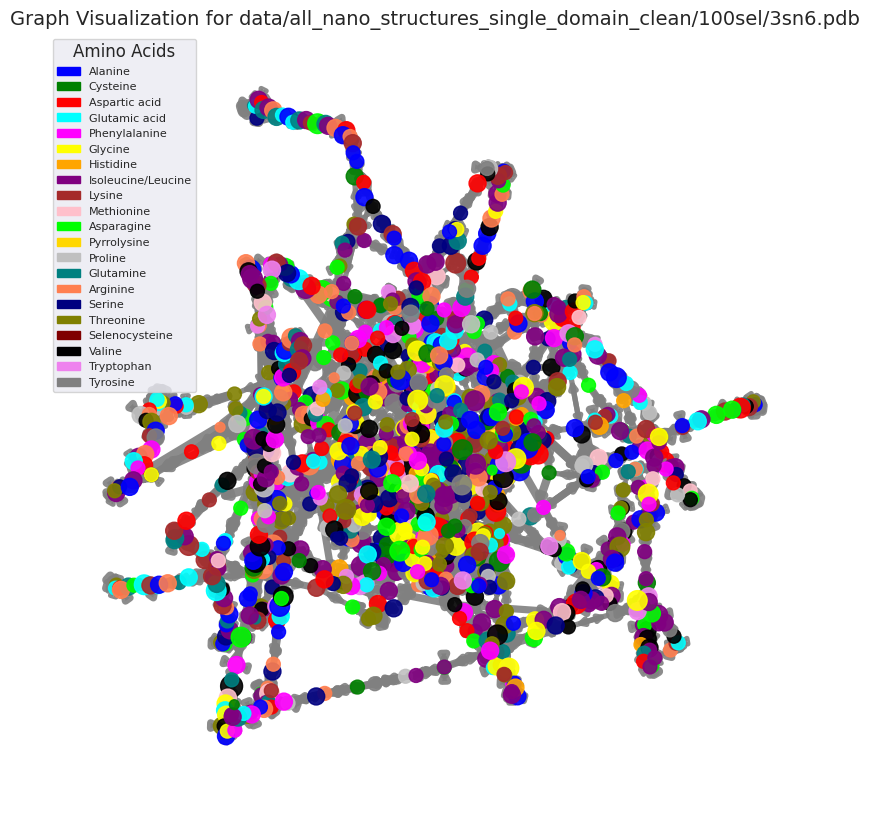

In [22]:
# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph_aminoacids(data, pdb_file)

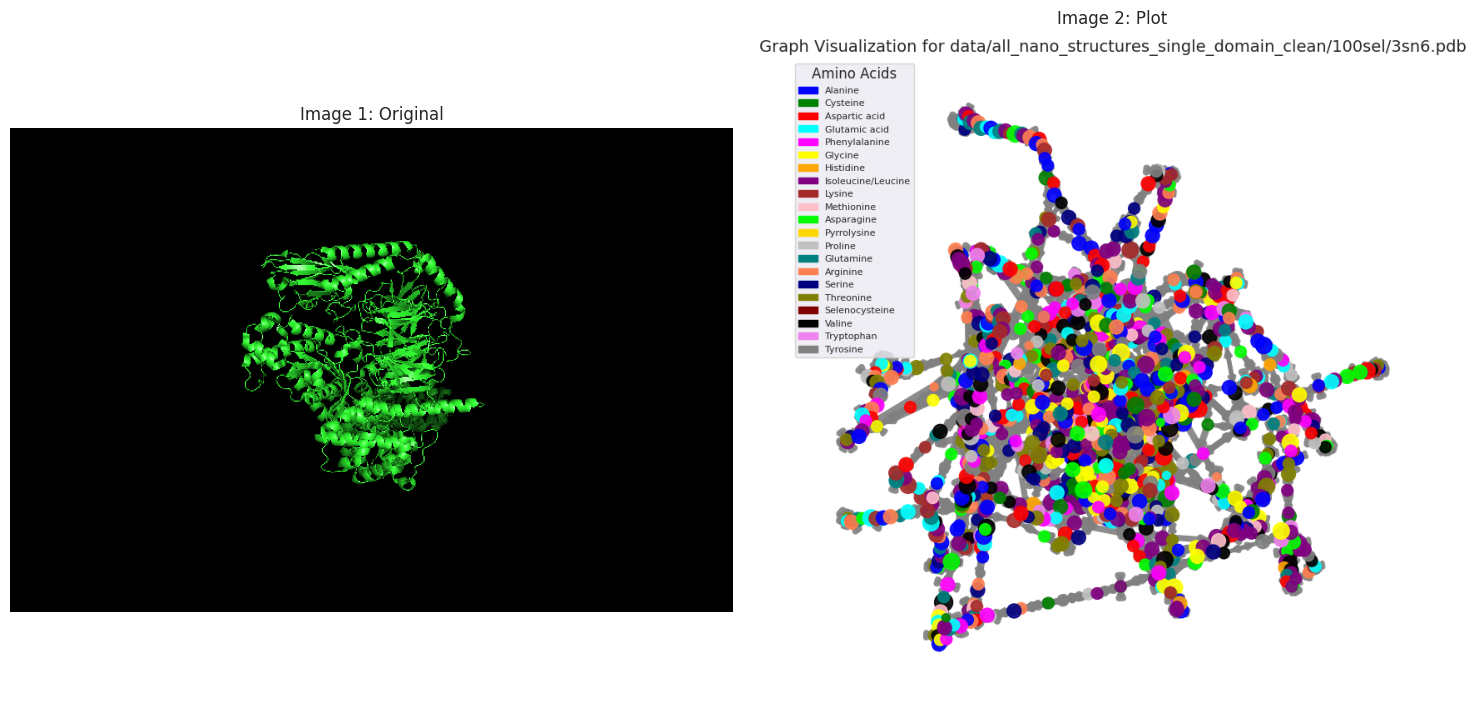

In [23]:
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

# Paths to your images
image_path_1 = "data/mab_dataset/3sn6.png"
image_path_2 = "data/mab_dataset/3sn6_plot.png"

# Open the images using PIL
image_1 = Image.open(image_path_1)
image_2 = Image.open(image_path_2)

# Create a matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns

# Display the first image
axes[0].imshow(image_1)
axes[0].axis('off')  # Hide axes
axes[0].set_title("Image 1: Original")

# Display the second image
axes[1].imshow(image_2)
axes[1].axis('off')  # Hide axes
axes[1].set_title("Image 2: Plot")

# Show the images
plt.tight_layout()
plt.show()


# Dataloader

In [32]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

def split_and_batch_graphs(graphs, batch_size=16, train_ratio=0.8, seed=42):
    """
    Split the graphs into train and test datasets, and create DataLoaders for batching.

    Parameters:
    - graphs (list): List of `torch_geometric.data.Data` graphs.
    - batch_size (int): Batch size for the DataLoader.
    - train_ratio (float): Proportion of data to use for training.
    - seed (int): Random seed for reproducibility.

    Returns:
    - train_loader (DataLoader): DataLoader for the training set.
    - test_loader (DataLoader): DataLoader for the testing set.
    """
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Split into train and test sets
    train_graphs, test_graphs = train_test_split(graphs, train_size=train_ratio, random_state=seed)
    
    # Create DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [33]:
# Unpack graphs
graph_data = [graph for _, graph in graphs]  # Extract only the `Data` objects

# Split and batch the graphs
train_loader, test_loader = split_and_batch_graphs(graph_data, batch_size=16, train_ratio=0.8, seed=42)

# Optional: Keep file names for reference
pdb_files = [pdb_file for pdb_file, _ in graphs]

# Example: Iterate through training batches
for batch in train_loader:
    print(batch)  # This should now work as expected


DataBatch(x=[9738, 8], edge_index=[2, 38952], edge_attr=[38952, 1], batch=[9738], ptr=[17])
DataBatch(x=[9957, 8], edge_index=[2, 39828], edge_attr=[39828, 1], batch=[9957], ptr=[17])
DataBatch(x=[9116, 8], edge_index=[2, 36464], edge_attr=[36464, 1], batch=[9116], ptr=[17])
DataBatch(x=[7731, 8], edge_index=[2, 30924], edge_attr=[30924, 1], batch=[7731], ptr=[17])
DataBatch(x=[12995, 8], edge_index=[2, 51980], edge_attr=[51980, 1], batch=[12995], ptr=[17])


# GTA VAE

## Architecture

In [75]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv, global_mean_pool
from torch_geometric.data import Batch


class GTA_VAE(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, latent_dim):
        super(GTA_VAE, self).__init__()
        self.node_in_dim = node_in_dim
        self.edge_in_dim = edge_in_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = hidden_dim  # Use hidden_dim for consistency

        # Encoder
        self.conv1 = TransformerConv(node_in_dim, hidden_dim, edge_dim=edge_in_dim, heads=4)
        self.conv2 = TransformerConv(hidden_dim * 4, hidden_dim, edge_dim=edge_in_dim, heads=4)
        self.node_pool = global_mean_pool

        # Latent Space
        self.fc_mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = torch.nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc_decode = torch.nn.Linear(latent_dim, hidden_dim)  # Adjust to match latent_dim
        self.conv_decode1 = TransformerConv(hidden_dim, hidden_dim, edge_dim=edge_in_dim, heads=4)
        self.conv_decode2 = TransformerConv(hidden_dim, node_in_dim, edge_dim=edge_in_dim, heads=1)


# class GTA_VAE(torch.nn.Module):
#     def __init__(self, node_in_dim, edge_in_dim, hidden_dim, latent_dim):
#         super(GTA_VAE, self).__init__()
#         self.node_in_dim = node_in_dim
#         self.edge_in_dim = edge_in_dim
#         self.hidden_dim = hidden_dim
#         self.latent_dim = latent_dim

#         # Encoder
#         self.conv1 = TransformerConv(node_in_dim, hidden_dim, edge_dim=edge_in_dim, heads=4)
#         self.conv2 = TransformerConv(hidden_dim * 4, hidden_dim, edge_dim=edge_in_dim, heads=4)
#         self.node_pool = global_mean_pool

#         # # Latent Space
#         # self.fc_mu = torch.nn.Linear(hidden_dim, latent_dim)  # Mean of latent space
#         # self.fc_logvar = torch.nn.Linear(hidden_dim, latent_dim)  # Log variance of latent space
#         # Latent Space
#         self.fc_mu = torch.nn.Linear(512, latent_dim)  # Adjust in_features to match the pooled size
#         self.fc_logvar = torch.nn.Linear(512, latent_dim)

        # Decoder
        self.fc_decode = torch.nn.Linear(latent_dim, hidden_dim)
        self.conv_decode1 = TransformerConv(hidden_dim, hidden_dim, edge_dim=edge_in_dim, heads=4)
        #self.conv_decode2 = TransformerConv(hidden_dim * 4, node_in_dim, edge_dim=edge_in_dim, heads=4)
        self.conv_decode2 = TransformerConv(hidden_dim, node_in_dim, edge_dim=edge_in_dim, heads=1)

    # def encode(self, x, edge_index, edge_attr, batch):
    #     """Encode graph to latent space."""
    #     x = F.relu(self.conv1(x, edge_index, edge_attr))
    #     x = F.relu(self.conv2(x, edge_index, edge_attr))
    #     x = self.node_pool(x, batch)  # Pool node embeddings into a graph embedding
    #     mu = self.fc_mu(x)
    #     logvar = self.fc_logvar(x)
    #     return mu, logvar

    def encode(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        print(f"Shape after conv1: {x.shape}")  # Debugging step
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        print(f"Shape after conv2: {x.shape}")  # Debugging step
        x = self.node_pool(x, batch)  # Pool node embeddings into graph embedding
        print(f"Shape after pooling: {x.shape}")  # Debugging step
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick for VAE."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std



    def decode(self, z, edge_index, edge_attr, batch):

        # Broadcast graph-level embeddings (z) to node-level using batch
        z_expanded = z[batch]  # Map graph embeddings to nodes using the batch tensor
        print(f"Shape of z_expanded: {z_expanded.shape}")  # Debugging step

        # Decode node features
        x = F.relu(self.fc_decode(z_expanded))
        print(f"Shape after fc_decode: {x.shape}")  # Debugging step
        x = F.relu(self.conv_decode1(x, edge_index, edge_attr))
        print(f"Shape after conv_decode1: {x.shape}")  # Debugging step
        x = self.conv_decode2(x, edge_index, edge_attr)
        print(f"Shape after conv_decode2: {x.shape}")  # Debugging step
        return x


    # def decode(self, z, edge_index, edge_attr):
    #     print(f"Shape of latent vector z: {z.shape}")  # Debugging step
    #     x = F.relu(self.fc_decode(z))
    #     print(f"Shape after fc_decode: {x.shape}")  # Debugging step
    #     x = F.relu(self.conv_decode1(x, edge_index, edge_attr))
    #     print(f"Shape after conv_decode1: {x.shape}")  # Debugging step
    #     x = self.conv_decode2(x, edge_index, edge_attr)
    #     print(f"Shape after conv_decode2: {x.shape}")  # Debugging step
    #     return x
    
    
    # def decode(self, z, edge_index, edge_attr):
    #     """Decode latent space to reconstruct the graph."""
    #     x = F.relu(self.fc_decode(z))
    #     x = F.relu(self.conv_decode1(x, edge_index, edge_attr))
    #     x = self.conv_decode2(x, edge_index, edge_attr)
    #     return x

    def forward(self, x, edge_index, edge_attr, batch):
        """Forward pass through the VAE."""
        # Encoder
        mu, logvar = self.encode(x, edge_index, edge_attr, batch)
        z = self.reparameterize(mu, logvar)

        # Decoder
        x_recon = self.decode(z, edge_index, edge_attr, batch)
        return x_recon, mu, logvar


## Loss 

In [76]:
def vae_loss(x, x_recon, mu, logvar):
    """VAE loss function combining reconstruction loss and KL divergence."""
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')  # Reconstruction Loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence
    return recon_loss + kl_loss


## Training Loop

In [77]:
from torch.optim import Adam

# Training function
def train_gta(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)  # Move batch to GPU/CPU
        optimizer.zero_grad()

        # Forward pass
        x_recon, mu, logvar = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

        # Compute loss
        loss = vae_loss(batch.x, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Evaluation function
def evaluate_gta(model, test_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            x_recon, mu, logvar = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            loss = vae_loss(batch.x, x_recon, mu, logvar)
            total_loss += loss.item()

    return total_loss / len(test_loader)


## Initialize all

In [78]:
# Initialize model, optimizer, and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GTA_VAE(node_in_dim=8, edge_in_dim=1, hidden_dim=128, latent_dim=64).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

## Train

In [79]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    train_loss = train_gta(model, train_loader, optimizer, device)
    test_loss = evaluate_gta(model, test_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Shape after conv1: torch.Size([9482, 512])
Shape after conv2: torch.Size([9482, 512])
Shape after pooling: torch.Size([16, 512])
Shape of z_expanded: torch.Size([9482, 64])
Shape after fc_decode: torch.Size([9482, 128])
Shape after conv_decode1: torch.Size([9482, 512])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (9482x512 and 128x8)